# Utility Functions

In [45]:
# type annotations
from typing import List, Set, Tuple
from datetime import datetime, date
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
from praw import Reddit
from psaw import PushshiftAPI
import spacy
from spacy.lang.en import English
from spacy.tokens import DocBin
nlp = spacy.load("en_core_web_sm")

In [67]:
def word_per_year(df: pd.DataFrame, words: List[str], user_counts: List[int]) -> pd.DataFrame:
    """
    Find the number of occurrences of the word per year in the df.
    Also returns a column with word counts normalized by active user counts.
    
    Note: assumes columns names "text" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    check_in = lambda text: 1 if len(set(words) & set(str(text).split())) > 0 else 0
    countw = lambda year: df.loc[df.year == year, "lower_text"].apply(check_in).sum()
    word_counts: List[int] = [countw(year) for year in years]
    wc_norm: List[float] = [w / u for w, u in zip(word_counts, user_counts)]
    return pd.DataFrame({"years": years, "word_counts": word_counts, "wc_norm": wc_norm})


def append_wc(df: pd.DataFrame, words: List[List[str]], user_counts: List[int]) -> pd.DataFrame:
    """Generates a dataframe with multiple word counts for visualization."""
    wc_df = ft.reduce(lambda acc, w: acc.append(word_per_year(df, w, user_counts)), words, pd.DataFrame())
    nyear = df.year.unique().shape[0]
    word_arr = ft.reduce(lambda acc, w: acc + [w[0]] * nyear, words, [])
    wc_df["words"] = word_arr
    return wc_df


def user_ents(u: str):
    """Get all entities associated with a given user."""
    grouped_ents = ents_df.loc[ents_df["username"] == u, :]["ents"].tolist()
    return ft.reduce(lambda x, y: x + y, grouped_ents, [])


def ents_by_type(ents, etype):
    """Get the text for entities of the given type from the given ents."""
    etypes = [e.text.lower().strip(".") for e in ents if e.label_ == etype]
    return etypes


def row_with_kw(df: pd.DataFrame, kw: str):
    """Returns row indexes of dataframe with ents with the given keyword."""
    return [i for i, ents in enumerate(ents_df["ents"].tolist()) 
            if kw in [str(e).lower() for e in ents]]

def disk_to_spacy(fp: str) -> List[English]:
    """Read spacy documents from disk."""
    docbin = DocBin().from_bytes(open(fp, "rb").read())
    disk_docs = docbin.get_docs(nlp.vocab)
    disk_docsl = list(disk_docs)
    return disk_docsl

def df_by_ent(df, e_name):
    """subset an entity df by the given ent."""
    sub_df = df.copy()
    sub_df[e_name] = sub_df["ents"].apply(lambda ents: [e for e in ents if e.label_ == e_name])
    sub_df[e_name] = sub_df[e_name].apply(lambda ents: ents if len(ents) > 0 else None)
    return sub_df.dropna()

def df_by_user(df, user):
    return df.loc[df["username"] == user, :]

def top_ents(df, e_name):
    """Get most frequent entities"""
    names = [e.text.lower() for e in list(it.chain.from_iterable(df[e_name].tolist()))]
    return Counter(names)

def search_ent(df, word, e_name):
    idx = [i for i, ents in enumerate(df[e_name].tolist())
           if word in [e.text for e in ents]]
    return df.iloc[idx,:]


# Read in data

In [4]:
# general processing
import pymongo
from utils import utc_to_dt, COLL, PSAW, PRAW
from tqdm import tqdm
from collections import Counter

In [5]:
# read in full mongo collection
res = COLL.find({})
df = pd.DataFrame(res)

In [9]:
# read in top n posting histories
raw_df = pd.read_csv("data/histories.csv")
hist_spacy = disk_to_spacy("data/histories.spacy")
spacy_idx = pd.read_csv("data/spacy_idx.csv", header=None, squeeze=True)

In [10]:
# add spacy docs to hist df
hist_df = raw_df.copy()
idx_to_spacy = dict(zip(spacy_idx.tolist(), hist_spacy))
spacy_col = [idx_to_spacy[idx] if idx in idx_to_spacy.keys() else None
             for idx in hist_df.index]
hist_df["spacy"] = spacy_col
hist_df = hist_df.dropna()

# User Histories

In [13]:
# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

## User Plots

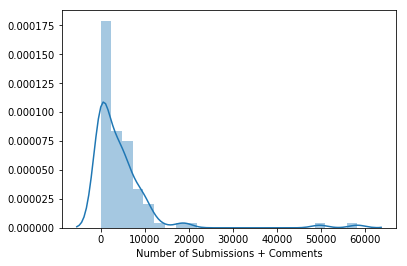

In [14]:
user_counts = hist_df.groupby("username").count().sort_values("id").reset_index()
ax = sns.distplot(user_counts["id"].tolist())
ax.set(xlabel="Number of Submissions + Comments")
plt.show()

## Extract entities

In [69]:
hist_df.columns

Index(['username', 'text', 'subreddit', 'is_sub', 'id', 'spacy', 'ents',
       'gpe'],
      dtype='object')

In [15]:
hist_df["ents"] = hist_df["spacy"].apply(lambda sp: list(sp.ents) if len(sp.ents) > 0 else None)
hist_df = hist_df.dropna()

In [35]:
# extract gpe locations
gpe_df = df_by_ent(hist_df, "GPE")

In [64]:
gpe_df["username"].unique()

array(['MetroMaker', 'OlDirtyBurton', 'NoseCandiez', 'fat_loser_junkie',
       'OxyJay', 'chilltownb', 'gangsta232', 'OxyCaughtIn',
       'Johndough1066', 'DawgfoodMN', 'Jangles710', 'dopiedude',
       'FlipFlopSuicide', 'ziplocfullacock', 'Dopana', 'fuckjoey',
       'Prettyeyesforasnake', 'inthea215', 'vogelsyn', 'xKingxShawnx',
       'thechilldboy', 'Southern_psychonaut', 'schizoidparanoid',
       'Cal_throwaway', 'HeroinPillsLovecraft', 'Someone_Who_Isnt_You',
       'Phy_Scootman', 'kaif_veenis', 'Gutterlungz1', 'chippersan',
       'boofk', 'gunmetalblue60', 'TakinLosses1', 'Meowopesmeow',
       'Diactylmorphinefiend', 'Joe11290', 'JuicyJay', 'Catman12000',
       'tealspirit', 'haamm', '40throw', 'riptaway',
       'IDKwhatTFimDoing168', 'jblake8912', 'inEuph0ria', 'Drabbstep21',
       'ohmygurd', 'CrystalFieldTheorist', 'hoLLa-', 'CivilizedInsanity',
       'spookydascary667', 'control_machine', 'SpacedCadetlucy',
       'ramsin1000', 'Mellomelll', 'drivethecarf', 'LiLbe

In [61]:
gpe_df.loc[:, ["username", "subreddit", "GPE", "text"]]

,username,subreddit,GPE,text
1,MetroMaker,opiates,[(MIGHT)],"I was trying to think of an opiate game that we could all play while under Stay-At-Home. Here's one.\n\n**The Stages of WDs**\n\nThe player tries to list in correct order all the Stages of WDs from initial to final. They player with the most stages in the correct order without dupes wins. For example, if the game was to drive your automobile to the liquor store, the stages would be\n\n1. Get in automobile\n2. Check gas\n3. Adjust seat\n4. Adjust mirrors\n5. Set radio\n6. Insert key\n7. Turn key\n8. etc., etc., etc\n9. ....\n\nFor **The Stages of WDs**, the first three stages MIGHT be (this is just an example and is not correct)\n\n1. Runny nose\n2. Puking\n3. Pooping\n\nYou get the idea. So who is a PLAYER in the GAME?"
2,MetroMaker,opiates,[(AMEN)],"I am so, so excited to be starting my new job tomorrow and I am NOT going to screw-up this job. NO nodding at work. NO deliveries at work. NO personal phone calls at work. NO flirting at work. NO nothing except WORK, WORK, WORK!!!\n\nI am going to do this job on the straight and narrow. I hope it's the incentive that I need to KICK ONCE AND FOR ALL! \n\nJUNKY JESUS please, please, PLEASE help me to stay on the right path this time! AMEN, AMEN, AMEN!"
10,MetroMaker,opiates,[(JJ)],"Junky Jesus is real! I was down to my last $5 and it was only Wednesday. DAMN! Why did I pay my stupid bills? I have two pillows, but I only use one. I decided to switch up tonight and use my other pillow. I laid down my head, worrying about getting sick, but something felt weird in my pillow. Could it be? YES! I found $120 hidden in the pillow case. HALLELUJAH! JJ IS REAL! CAN I GET A WITNESS?"
13,MetroMaker,cats,"[(Kitty), (Kitty), (Kitty)]","The cat's name is Gizmo, but she'll only come to ""Here Kitty, Kitty, Kitty."" What did I do wrong? BTW she's a rescue."
29,MetroMaker,u_MetroMaker,[(America)],"This Chomo will likely get 3 years and get out in 18 months, but you get caught with a dub or a 30 and its 5 years. In fact, Chomo may not get **anytime at all** because the kids are too young to testify and therefore there are no witnesses to the crime. And they call that Justice in America. At least the dad got in some pretty good licks in judging by Chomo's face. LOL\n\n [https://patch.com/virginia/fredericksburg/father-beats-family-member-found-half-nude-children-police](https://patch.com/virginia/fredericksburg/father-beats-family-member-found-half-nude-children-police)"
30,MetroMaker,opiates,[(Bangkok)],I'm watching Locked Up Abroad on National Geographic channel. I can't believe how foolish these people are smuggling H from Bangkok for some Nigerian guy. The penalty is either life in prison or death by hanging. I'd sleep at bus stations and beg on the streets before I'd do that. INCREDIBLE.
31,MetroMaker,opiates,[(Jail)],My biggest fear that could very well come true is KICKING IN JAIL. It just seems so very BRUTAL. How about a Kicking in Jail bedtime story or two?
32,MetroMaker,opiates,[(Mickeys)],"I thought that dBoy's bags were light, so I asked for advice on r/opiates about a cheap scale. Thanks to you guys, I received a lot of replies and I bought a $10 scale from Amazon that was delivered the other day.\n\nOn NYE (today), dBoy was in my area at the clinic and he stopped by my house for a NYE drink (for once he brought his own Mickeys). I bought a half from him and only then I broke-out my new scale. I put dBoy's half on my scale and it registered 0.50 g, which is light considering the ziploc bag's weight. dBoy said ""Your scale is wrong. I know my shit is right"". I asked him to Google the weight of a quarter, I hit my coin jar and I put a quarter on my new scale. Lo and behold, my scale registers 0.57 g, while the internet said that a quarter = 0.567 g ([https://www.reference.com/business-finance/much-quarter-weigh-a84ccf4c36e1915f](https://www.reference.com/business-finance/much-quarter-weigh-a84ccf4c36e1915f)), which is good enough

In [68]:
search_ent(gpe_df, "newark", "GPE")

,username,text,subreddit,is_sub,id,spacy,ents,gpe,GPE
54118,OxyJay,"Pure heroin? Maybe 1-5 mg would equal 30-60 roxi. Most people in Chicago, newark, philly etc are getting 10-20% purity I believe and they have the best dope in the country so you do the math",opiates,False,cch52dy,"(Pure, heroin, ?, Maybe, 1, -, 5, mg, would, equal, 30, -, 60, roxi, ., Most, people, in, Chicago, ,, newark, ,, philly, etc, are, getting, 10, -, 20, %, purity, I, believe, and, they, have, the, best, dope, in, the, country, so, you, do, the, math)","[(1), (30), (Chicago), (newark), (10, -, 20, %)]","[(Chicago), (newark)]","[(Chicago), (newark)]"
210924,boofk,"I have been wondering about this for a minute. Ive gotten bags from one source in newark for almost three years now and everytime this shit holds me for 36+ hours. Normally i start getting sick 10-12 hours after my last dose. Another strange thing about it is the color varies from batch to batch(brown-tan-white) but the smell and taste is always the same. Ive never had dope taste like this. Its not vinegary at all, but the dope is very good. The bags i get from queens are the same potency or better, but still hold the normal 10-12 hours. Ive wondered for a while if the newark bags i get are cut with methadone or some other long acting opiate. From a business stand point it doesnt make sense. You want people to get sick quick so they have to buy more. It just doesnt make sense though. These bags are always really good, but ive had better bags that didnt hold me half the time these do. It sucks for me cause im on sub and i like gettig high for a day or two, but i hate having to wait a day and a half to redose my sub to avoid pwds.",opiates,False,cmxoi4g,"(I, have, been, wondering, about, this, for, a, minute, ., I, ve, gotten, bags, from, one, source, in, newark, for, almost, three, years, now, and, everytime, this, shit, holds, me, for, 36, +, hours, ., Normally, i, start, getting, sick, 10, -, 12, hours, after, my, last, dose, ., Another, strange, thing, about, it, is, the, color, varies, from, batch, to, batch(brown, -, tan, -, white, ), but, the, smell, and, taste, is, always, the, same, ., I, ve, never, had, dope, taste, like, this, ., Its, not, vinegary, at, all, ,, but, the, dope, is, very, good, ., The, ...)","[(a, minute), (one), (newark), (almost, three, years), (36, +, hours), (10, -, 12, hours), (10, -, 12, hours), (newark), (half), (gettig), (day), (two), (a, day, and, a, half)]","[(newark), (newark), (gettig)]","[(newark), (newark), (gettig)]"
211011,boofk,"Yeah i know. My tolerance is huge so if i sniff two bags and feel anything at all, then the dope is good. This shit is bitter as hell and tastes/smells like the bags i get from newark which are fire. This shit is still pretty good, it just isnt kicking my ass like i thpught it would going on the taste/smell.",opiates,False,cma3ryp,"(Yeah, i, know, ., My, tolerance, is, huge, so, if, i, sniff, two, bags, and, feel, anything, at, all, ,, then, the, dope, is, good, ., This, shit, is, bitter, as, hell, and, tastes, /, smells, like, the, bags, i, get, from, newark, which, are, fire, ., This, shit, is, still, pretty, good, ,, it, just, is, nt, kicking, my, ass, like, i, thpught, it, would, going, on, the, taste, /, smell, .)","[(two), (newark)]",[(newark)],[(newark)]
211128,boofk,"The most common way dope is sold in the 757 is in clear gelcaps, but in the past 2-3 years ive been seeing stamps a lot more often. For 2 years straight we were getting stamps straight from newark and queens but i havent seen those in a few months, but still see stamps that were put together down here. And the third most common way its sold im corner bags by weight. I still prefer getting bundles of caps or stamps. When its sold by weight you can get it for $120/g but its not very good. Good shit is $180-200/g, but i still feel a the caps or bags is better even if they have some cut on them. You can get 20 fire caps for $150-160 and even though the quality 

In [66]:
top_ents(df_by_user(gpe_df, "Dopana"), "GPE").most_common()

[('xanax', 60),
 ('kinda', 37),
 ('u.s.', 29),
 ('newark', 21),
 ('us', 19),
 ('america', 18),
 ('florida', 16),
 ('turkey', 13),
 ('mexico', 13),
 ('pwd', 12),
 ('alexandria', 11),
 ('baltimore', 10),
 ('trenton', 9),
 ('russia', 8),
 ('opana', 8),
 ('china', 8),
 ('canada', 8),
 ('jersey', 7),
 ('new brunswick', 7),
 ('molly', 7),
 ('valium', 7),
 ('alaska', 7),
 ('louisiana', 6),
 ('d.c.', 6),
 ('new york', 6),
 ('miami', 6),
 ('goodluck', 5),
 ('fl', 5),
 ('kratom', 5),
 ('tampa', 5),
 ('south jersey', 5),
 ('marijuana', 5),
 ('netflix', 4),
 ("hawai'i", 4),
 ('warren county', 4),
 ('north jersey', 4),
 ('jj', 4),
 ('blotter', 3),
 ('dr', 3),
 ('ny', 3),
 ('pa', 3),
 ('manhattan', 3),
 ("iv'ing", 3),
 ('new jersey', 3),
 ('the united states', 3),
 ('uk', 3),
 ('afghanistan', 3),
 ('ohio', 3),
 ('morocco', 3),
 ('philadelphia', 3),
 ('portugal', 3),
 ('y.o.', 3),
 ('montana', 3),
 ('chile', 3),
 ('london', 2),
 ('pedophilia', 2),
 ('thisbe', 2),
 ('adderall', 2),
 ('easton', 2),
 ('

In [40]:
pd.set_option('display.max_colwidth', -1)
gpe_df.loc[:, ["username", "subreddit", "GPE", "text", ]]

,username,subreddit,GPE,text
1,MetroMaker,opiates,[(MIGHT)],"I was trying to think of an opiate game that we could all play while under Stay-At-Home. Here's one.\n\n**The Stages of WDs**\n\nThe player tries to list in correct order all the Stages of WDs from initial to final. They player with the most stages in the correct order without dupes wins. For example, if the game was to drive your automobile to the liquor store, the stages would be\n\n1. Get in automobile\n2. Check gas\n3. Adjust seat\n4. Adjust mirrors\n5. Set radio\n6. Insert key\n7. Turn key\n8. etc., etc., etc\n9. ....\n\nFor **The Stages of WDs**, the first three stages MIGHT be (this is just an example and is not correct)\n\n1. Runny nose\n2. Puking\n3. Pooping\n\nYou get the idea. So who is a PLAYER in the GAME?"
2,MetroMaker,opiates,[(AMEN)],"I am so, so excited to be starting my new job tomorrow and I am NOT going to screw-up this job. NO nodding at work. NO deliveries at work. NO personal phone calls at work. NO flirting at work. NO nothing except WORK, WORK, WORK!!!\n\nI am going to do this job on the straight and narrow. I hope it's the incentive that I need to KICK ONCE AND FOR ALL! \n\nJUNKY JESUS please, please, PLEASE help me to stay on the right path this time! AMEN, AMEN, AMEN!"
10,MetroMaker,opiates,[(JJ)],"Junky Jesus is real! I was down to my last $5 and it was only Wednesday. DAMN! Why did I pay my stupid bills? I have two pillows, but I only use one. I decided to switch up tonight and use my other pillow. I laid down my head, worrying about getting sick, but something felt weird in my pillow. Could it be? YES! I found $120 hidden in the pillow case. HALLELUJAH! JJ IS REAL! CAN I GET A WITNESS?"
13,MetroMaker,cats,"[(Kitty), (Kitty), (Kitty)]","The cat's name is Gizmo, but she'll only come to ""Here Kitty, Kitty, Kitty."" What did I do wrong? BTW she's a rescue."
29,MetroMaker,u_MetroMaker,[(America)],"This Chomo will likely get 3 years and get out in 18 months, but you get caught with a dub or a 30 and its 5 years. In fact, Chomo may not get **anytime at all** because the kids are too young to testify and therefore there are no witnesses to the crime. And they call that Justice in America. At least the dad got in some pretty good licks in judging by Chomo's face. LOL\n\n [https://patch.com/virginia/fredericksburg/father-beats-family-member-found-half-nude-children-police](https://patch.com/virginia/fredericksburg/father-beats-family-member-found-half-nude-children-police)"
30,MetroMaker,opiates,[(Bangkok)],I'm watching Locked Up Abroad on National Geographic channel. I can't believe how foolish these people are smuggling H from Bangkok for some Nigerian guy. The penalty is either life in prison or death by hanging. I'd sleep at bus stations and beg on the streets before I'd do that. INCREDIBLE.
31,MetroMaker,opiates,[(Jail)],My biggest fear that could very well come true is KICKING IN JAIL. It just seems so very BRUTAL. How about a Kicking in Jail bedtime story or two?
32,MetroMaker,opiates,[(Mickeys)],"I thought that dBoy's bags were light, so I asked for advice on r/opiates about a cheap scale. Thanks to you guys, I received a lot of replies and I bought a $10 scale from Amazon that was delivered the other day.\n\nOn NYE (today), dBoy was in my area at the clinic and he stopped by my house for a NYE drink (for once he brought his own Mickeys). I bought a half from him and only then I broke-out my new scale. I put dBoy's half on my scale and it registered 0.50 g, which is light considering the ziploc bag's weight. dBoy said ""Your scale is wrong. I know my shit is right"". I asked him to Google the weight of a quarter, I hit my coin jar and I put a quarter on my new scale. Lo and behold, my scale registers 0.57 g, while the internet said that a quarter = 0.567 g ([https://www.reference.com/business-finance/much-quarter-weigh-a84ccf4c36e1915f](https://www.reference.com/business-finance/much-quarter-weigh-a84ccf4c36e1915f)), which is good enough

## Explore entities by user

In [326]:
flat_ents = ft.reduce(lambda x, y: x + y, ents_df["ents"].tolist(), [])

In [357]:
# get observations with ents that match a keyword
atlanta_idx = row_with_kw(ents_df, "atlanta")
atlanta_df = ents_df.iloc[atlanta_idx, :]

In [347]:
# get entities for a given user
u1_ents = user_ents("realcat67")
u1_gpe = ents_by_type(u1_ents, "GPE")

## Display entities with displaCy

In [ ]:
from spacy import displacy

In [303]:
# visualize entities
docs = ents_df["spacy"].tolist()[900:902]
vis_docs = [d for d in docs if len(d.ents) > 0]
for i, d in enumerate(vis_docs):
    print("Doc:", i)
    display(HTML(displacy.render(d, style='ent', page=True)))

Doc: 0


Doc: 1


In [46]:
users_df["gpes"] = users_df["spacy"].apply(lambda x: [e for e in x.ents if e.label_ == "GPE"])

In [78]:
gpes_by_user

,username,gpes
0,FashionablyFake,"[(Kilos), (soooo), (Dallas), (Whatevz), (bk), ..."
1,KickerS12X,"[(kiddo), (Vermont), (xanax), (north, troy), (..."
2,OlDirtyBurton,"[(APVP), (US), (Adderall), (US), (US), (Tina),..."
3,chasing-d0pamine,"[(Wharton), (Adderall), (america), (Adderall),..."
4,heroinking,"[(turkey), (turkey), (APVP), (APVP), (turkey),..."
5,spinderella69,"[(NY), (Molly), (kinda), (Kratom), (Kratom), (..."
6,street_philatelist,"[(Fentanyl, Warnings, State), (SN), (Florida),..."
7,traceyh415,"[(R.C.), (Chicago), (Phoenix), (AZ), (Seattle)..."


In [73]:
gpes_by_user = users_df.groupby("username").agg({"gpes": lambda x: ft.reduce(lambda acc, y: acc + y, x)}).reset_index()

In [83]:
Counter([e.text for e in gpes_by_user["gpes"][4]]).most_common()

[('APVP', 127),
 ('Adderall', 107),
 ('US', 54),
 ('Seroquel', 25),
 ('Xanax', 18),
 ('USA', 16),
 ('Discord', 11),
 ('Wisconsin', 9),
 ('APHP', 9),
 ('China', 8),
 ('America', 8),
 ('UK', 8),
 ('LE', 7),
 ('Canada', 7),
 ('California', 7),
 ('turkey', 6),
 ('Tylenol', 6),
 ('Florida', 6),
 ('Missouri', 6),
 ('Mexico', 5),
 ('Walmart', 5),
 ('Vendor', 5),
 ('Minneapolis', 4),
 ('MDPV', 4),
 ('M1', 4),
 ('Tina', 4),
 ('Ketamine', 4),
 ('Molly', 4),
 ('Oxycodone', 4),
 ('Miami', 3),
 ('Opana', 3),
 ('meth', 3),
 ('Valium', 3),
 ('Ambien', 3),
 ('Temazepam', 3),
 ('Pentylone', 3),
 ('Hydrocodone', 3),
 ('Codeine', 3),
 ('JJ', 3),
 ('PWD', 3),
 ('Minnesota', 3),
 ('Eminem', 3),
 ('pedophilia', 3),
 ('china', 2),
 ('LSD', 2),
 ('Oxy', 2),
 ('Russia', 2),
 ('Bitcoin', 2),
 ('India', 2),
 ('Ativan', 2),
 ('Klonopin', 2),
 ('Utah', 2),
 ('blotter', 2),
 ('Vicodin', 2),
 ('xanax', 2),
 ('tina', 2),
 ('incognito', 2),
 ('Houston', 2),
 ('Elvis', 2),
 ('Pornhub', 2),
 ('adderall', 2),
 ('Nevada',

In [72]:
gpes_by_user["gpes"][3]

Counter({(Wharton, 1): 1,
         (Adderall, 1): 1,
         (america, 1): 1,
         (Adderall, 1): 1,
         (US, 1): 1,
         (US, 1): 1,
         (US, 1): 1,
         (US, 1): 1,
         (Seroquel, 1): 1,
         (APVP, 1): 1,
         (APVP, 1): 1,
         (va va va, 1): 1,
         (kinda, 1): 1,
         (Adderall, 1): 1,
         (Suburbia, 1): 1,
         (Xanax, 1): 1,
         (US, 1): 1,
         (Ulta, 1): 1,
         (India, 1): 1,
         (New York, 1): 1,
         (New York, 1): 1,
         (Adderall, 1): 1,
         (Aexandria, 1): 1,
         (Mexico, 1): 1,
         (US, 1): 1,
         (RX, 1): 1,
         (Vitamultin, 1): 1,
         (turkey, 1): 1,
         (turkey, 1): 1,
         (Ulta, 1): 1,
         (Kanye, 1): 1,
         (APVP, 1): 1,
         (APVP, 1): 1,
         (blockchain, 1): 1,
         (Adderall, 1): 1,
         (Canada, 1): 1,
         (APVP, 1): 1,
         (Scotland, 1): 1,
         (Scotland, 1): 1,
         (Tumblr, 1): 1,
         

# Word Usage

In [57]:
vis_df = raw_df.copy()
vis_df["year"] = vis_df["time"].apply(lambda x: x.year)

KeyError: 'time'

## Location Mentions

In [83]:
# get raw and normalized word counts in df
# NOTE: words is a 2d list with:
# dim 1: a category to count and plot
# dim 2: aliases to include in that category.  can only be a single word for now
loc_words = [["boston", "beantown", "bos"], ["lawrence"], ["lowell"], ["manchester"], ["worcester"]]
loc_df = append_wc(df, loc_words, user_counts)

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

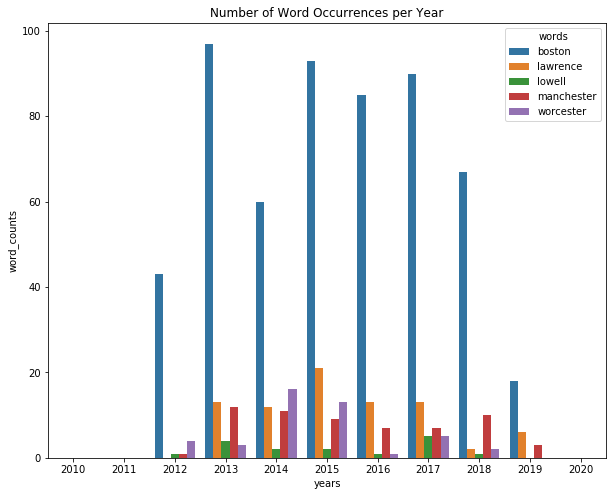

In [84]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="years", y="word_counts", hue="words", data=wc_df)
ax.set_title(f"Number of Word Occurrences per Year")

## Drug Mentions

In [85]:
drug_words = [["fentanyl", "fent", "fenty"], ["heroin"]]
drug_df = append_wc(full_df, drug_words, user_counts)

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

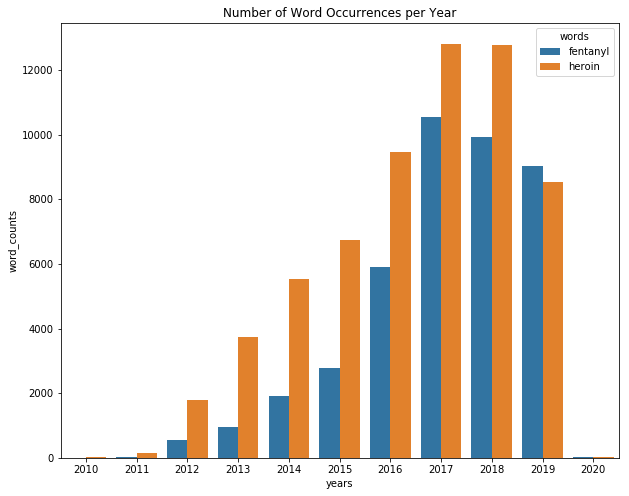

In [86]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="years", y="word_counts", hue="words", data=drug_df)
ax.set_title(f"Number of Word Occurrences per Year")

## Withdrawal Mentions

In [56]:
# get raw and normalized word counts in df
# NOTE: words is a 2d list with:
# dim 1: a category to count and plot
# dim 2: aliases to include in that category.  can only be a single word for now
loc_words = [["boston", "beantown", "bos"], ["lawrence"], ["lowell"], ["manchester"], ["worcester"]]
loc_df = append_wc(df, loc_words, user_counts)

KeyError: 'year'

Text(0.5, 1.0, 'Number of Word Occurrences per Year')

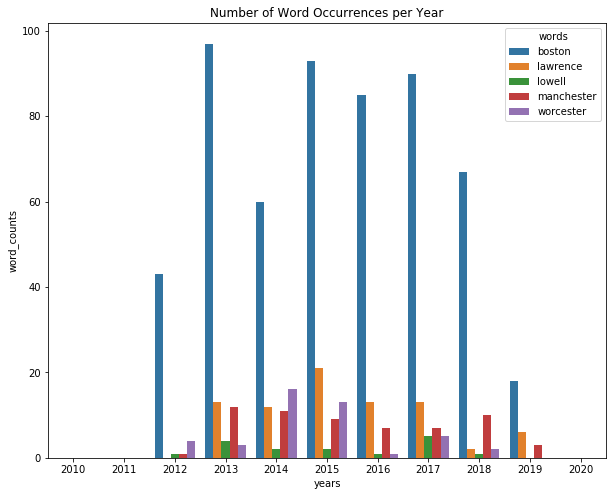

In [84]:
# plot y='word_counts' for raw counts or y='wc_norm' for norm counts
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="years", y="word_counts", hue="words", data=wc_df)
ax.set_title(f"Number of Word Occurrences per Year")

# Summative Visualizations

## Date Distributions

In [5]:
full_df["date"] = full_df.time.apply(lambda ts: date(ts.year, ts.month, ts.day))
date_groups = full_df.groupby("date").count().reset_index()

In [ ]:
df_19 = date_groups.loc[date_groups["date"] >= date(2019, 1, 1), :]
sns.barplot(x="date", y="hash", data=df_19)

## Number of Posts Over Time

### Count of Submissions Over Time

Text(0.5, 1.0, 'Number of r/opiates Submissions Over Time')

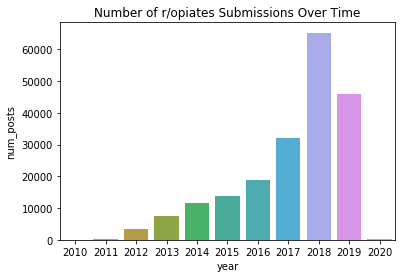

In [39]:
count_df = sub_df.groupby("year").count().reset_index().loc[:, ["year", "_id"]]
count_df.columns = ["year", "num_posts"]
norm_posts: List[float] = [p / u for p, u in zip(count_df["num_posts"], user_counts)]
ax = sns.barplot(x=count_df.year, y=count_df["num_posts"])
ax.set_title("Number of r/opiates Submissions Over Time")

### Count of Submissions + Comments Over Time

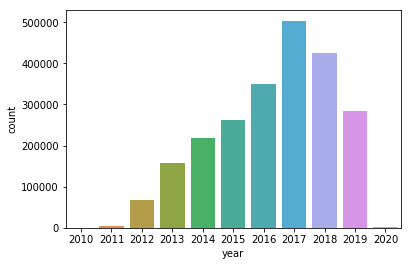

In [21]:
# group by year
query_str = { 
    "$group": { 
        "_id": { 
            "year": {"$year": "$time"}}, 
        "count": {
            "$sum": 1
        },
        "subs": {"$sum": 1}
    }
}
query = COLL.aggregate([query_str])

# extract data
query_li = list(query)
years = [str(it["_id"]["year"]) for it in query_li]
counts = [it["count"] for it in query_li]

# create dataframe
df = pd.DataFrame({"year": years, "count": counts})

# plot
sns.barplot(x="year", y="count", data=df)

### Count of Submissions + Real Comments

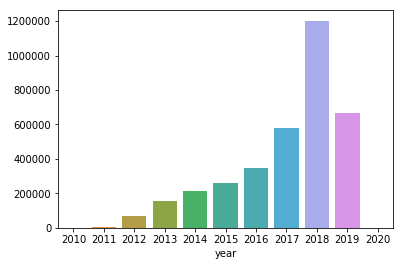

In [55]:
sub_df.query("year == '2017'").shape[0]
comms = sub_df.groupby("year")["num_comments"].sum().tolist()
subs = sub_df.groupby("year").count()
combined = [a + b for a, b in zip(comms, subs["hash"].tolist())]
sns.barplot(x=subs.index, y=combined)

### Real comments vs. extracted comments

In [44]:
real_comm_query = [
    {"$match": {
        "is_sub": True}},
    {"$group": {
        "_id": {"year": {"$year": "$time"}},
        "count": {"$sum": "$num_comments"}}}
]
real_res = COLL.aggregate(real_comm_query)
real_df = pd.DataFrame(list(real_res))
real_df["year"] = real_df["_id"].apply(lambda x: x["year"])

In [45]:
# group by year
raw_query = [
    {"$match": {"is_sub": False}},
    {"$group": {"_id": {"year": {"$year": "$time"}}, 
                "count": {"$sum": 1}}}
]
raw_res = COLL.aggregate(raw_query)
raw_df = pd.DataFrame(list(raw_res))
raw_df["year"] = raw_df["_id"].apply(lambda x: x["year"])

In [48]:
# combine dataframes
comm_df = real_df.merge(raw_df, on="year", how="inner")

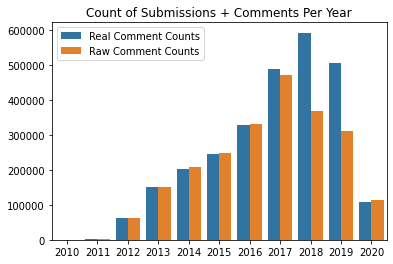

In [50]:
# plot
years = comm_df["year"].tolist() * 2
label = ["Real Comment Counts"] * comm_df.shape[0] + \
        ["Raw Comment Counts"] * comm_df.shape[0]
counts = comm_df["count_x"].tolist() + comm_df["count_y"].tolist()
ax = sns.barplot(x=years, y=counts, hue=label)
ax.set_title("Count of Submissions + Comments Per Year")
plt.show()

### Average Number of Comments Per Post Over Time

Text(0.5, 1.0, 'Average Number of Comments Per Post Over Time')

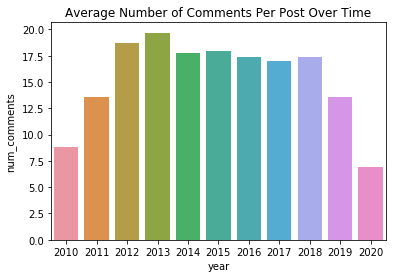

In [40]:
comm_df = sub_df.loc[:,["year", "num_comments"]].dropna().groupby("year")\
                                                .mean().reset_index()
ax = sns.barplot(x=comm_df.year, y=comm_df.num_comments)
ax.set_title("Average Number of Comments Per Post Over Time")

In [57]:
comm_counts = full_df.groupby("parent_id").count().reset_index()
comm_counts["new_par_id"] = comm_counts["parent_id"].apply(lambda x: x.replace("t1_", ""))

## Active Number of Users on R/Opiates Over Time

In [18]:
def users_per_year(df: pd.DataFrame) -> Tuple[List[str], List[int]]:
    """
    Find the number of unique users per year in the given df.
    
    Note: assumes columns names "username" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    user_counts: List[int] = [df.loc[df.year == year, "username"].unique().shape[0] for year in years]
    return years, user_counts

Text(0.5, 1.0, 'Number of r/opiates Active Users Over Time')

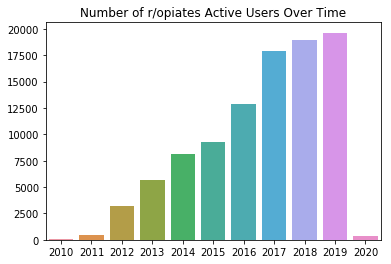

In [19]:
years, user_counts = users_per_year(full_df)
ax = sns.barplot(x=years, y=user_counts)
ax.set_title("Number of r/opiates Active Users Over Time")

## Frequency Table

In [245]:
freq_df = pd.DataFrame(list(COLL.find({})))
freq_df["year"] = freq_df.time.apply(lambda x: str(x.year))

In [246]:
freq_df["Threads"] = freq_df["is_sub"].apply(lambda x: 1 if x else 0)
freq_df["Comments"] = freq_df["is_sub"].apply(lambda x: 1 if (not x) else 0)
freq_df["Totals"] = [1] * freq_df.shape[0]
count_df = freq_df.groupby("year").sum().loc[:,["Threads", "Comments", "Totals"]]

In [247]:
count_df

,Threads,Comments,Totals
year,,,
2019,175.0,2162.0,2337.0
